Importing libraries

In [3]:
import numpy as np
from datetime import datetime
from itertools import groupby

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
import math
import torch as T
from torch.autograd import Variable
import numpy as np
import pdb
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
!pip install torchsummaryX --quiet
from torchsummaryX import summary as summaryX
from torchsummary import summary
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Preparing Seq_MNIST data set alpha=9, ends=5 as paper

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor()]),

    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor()])

)

def prepare_data(data):
  seq_data=[]
  seq_label=[]
  k=1
  temp_data=[]
  temp_label=[]
  ends=5
  alpha=9
  total=3*alpha+2*ends
  for image,label in data:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image=image*255
    temp_label.append(label)
    if k%4==1:
      for i in range(1,alpha+1,2):
        temp_data.append(image*0.1*(i))

      temp_data.append(image)

      for i in range(alpha):
        temp_data.append(image*0.1*(alpha-i))

    elif k%4==0:
      temp_data.append(image)
      l = len(temp_data)
      for i in range(alpha):
        temp_data[l-alpha+i]=temp_data[l-alpha+i]+image*0.1*(i)

        if (i+1)%2==1:
          temp_data.append(image*0.1*(alpha-i))
      seq_data.append(torch.cat(temp_data, dim=0).reshape((41,1,32,32)))
      seq_label.append(torch.tensor(temp_label).reshape((4,1)))
      temp_data=[]
      temp_label=[]
    else:
      l = len(temp_data)
      temp_data.append(image)
      for i in range(alpha):
        temp_data[l-alpha+i]=temp_data[l-alpha+i]+image*0.1*(i)
        temp_data.append(image*0.1*(alpha-i))
    k=k+1
  return torch.cat(seq_data, dim=1), torch.cat(seq_label, dim=1)

train_seq_image, train_seq_label = prepare_data(train_data)
test_seq_image, test_seq_label = prepare_data(test_data)


100%|██████████| 9912422/9912422 [00:00<00:00, 94313201.23it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26919043.07it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26067799.19it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4706158.29it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



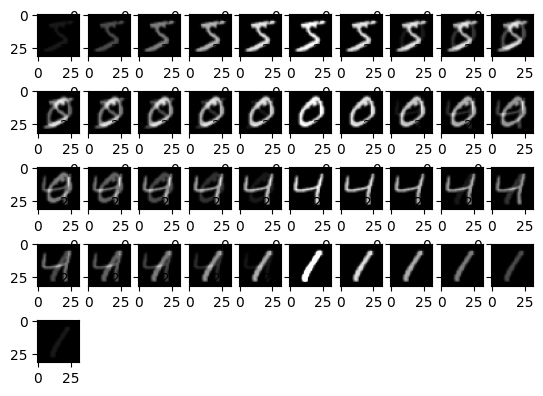

In [5]:
c=1
for i in train_seq_image[:,0,:,:]:

  plt.subplot(5, 10, c)
  plt.imshow(i.reshape(32,32), cmap='gray', vmin=0, vmax=255)
  c=c+1
plt.show()

LeNet++ implementation from Wen, Y., Zhang, K., Li, Z., Qiao, Y.: A discriminative feature learning approach for
deep face recognition. In: Proceedings of the European Conference on Computer
Vision. pp. 499–515. Springer (2016)


In [9]:
class LeNetpp(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten())

        self.fc = nn.Linear(2048, 3)
        self.relu = nn.PReLU()
        self.fc2 = nn.Linear(3,11)
        self.softmax= nn.Softmax(dim=1)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.fc(out)
        self.v = self.relu(out)
        self.f = self.fc2(self.v)
        out = self.softmax(self.f)

        return out

In [10]:
model = LeNetpp()

x = torch.randn(41,1,32,32)
output = model(x)
print(model)
print("output.shape : ",output.shape)

LeNetpp(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

Common parts of CTC and Radial CTC loss implemented using https://ogunlao.github.io/blog/2020/07/17/breaking-down-ctc-loss.html explanation

In [106]:
def ctc_loss_base(pred, token):
    '''
    :param pred: (Time, batch, voca_size+1)
    :param pred_len: (batch)
    :param token: (batch, U)
    :param token_len: (batch)
    '''
    if len(pred.shape)==3:
      Time, batch, L= pred.size(0), pred.size(1), pred.size(2)
      U = token.size(1)

      pred_token=pred[:,:,10].clone()

      for i in range(2*U):

        if i%2==1:
          pred_token=torch.cat((pred_token,pred[:,:,10].clone()), dim=2)
        else:
          pred_token=torch.cat((pred_token,pred[:,:,token[:,int(i/2)].clone()].clone()), dim=2)
      alpha=T.zeros(pred.shape)

      for t in range(Time):
        for s in range(2*U+1):
          if s==0 and t==0:
            alpha[0,:,0]=pred_token[0,:,0]
          elif s==1 and t==0:
            alpha[0,:,1]=pred_token[0,:,1]
          else:
            if s %2==0:
              if t>0:
                if s>0:
                  alpha[t,:,s] = (alpha[t-1,:,s]+ alpha[t-1,:,s-1])*pred_token[t,:,s]
                else:
                  alpha[t,:,s] = (alpha[t-1,:,s])*pred_token[t,:,s]
            else:
              if s>2:
                if t>1:
                  mask = token[:,int((s-1)/2)].clone()==token[:,int((s-3)/2)].clone()
                  alpha[t,mask,s] = (alpha[t-1,mask,s]+ alpha[t-1,mask,s-1])*pred_token[t,mask,s]
                  alpha[t,~mask,s] = (alpha[t-1,~mask,s]+alpha[t-1,~mask,s-1]+alpha[t-2,~mask,s-2])*pred_token[t,~mask,s]
                elif t>0:
                  alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1])*pred_token[t,:,s]

              else:

                if t<1:
                  alpha[t,:,s] = 0
                elif s<1:
                  alpha[t,:,s] = (alpha[t-1,:,s])*pred_token[t,:,s]
                elif t<2 or s<2:
                  alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1])*pred_token[t,:,s]
                else:
                  alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1]+alpha[t-2,:,s-2])*pred_token[t,:,s]

      beta = T.zeros(pred.shape)
      for tr in range(Time):
        for sr in range(2*U+1):
          t=Time-1-tr
          s=2*U-sr
          if s==2*U and t==Time-1:
            beta[s,:,t]=1
          elif s==2*U-1 and t==Time-1:
            beta[s,:,t]=1
          else:
            if s %2==0:
              if t<Time-1:
                if s<2*U:
                  beta[t,:,s] = (beta[t+1,:,s]*pred_token[t,:,s]+ beta[t+1,:,s+1]*pred_token[t,:,s+1])
                else:
                  beta[t,:,s] = (beta[t+1,:,s])*pred_token[t,:,s]
            else:
              if s<2*U-1 and t<Time-2:

                mask = token[:,int((s-1)/2)].clone()==token[:,int((s+1)/2)].clone()
                beta[t,mask,s] = (beta[t+1,mask,s]+ beta[t+1,mask,s+1])*pred_token[t,mask,s]
                beta[t,~mask,s] = (beta[t+1,~mask,s]+beta[t+1,~mask,s+1]+beta[t+2,~mask,s+2])*pred_token[t,~mask,s]
              else:
                if  t<Time-1:
                  if s<2*U:
                    beta[t,:,s] = (beta[t+1,:,s]*pred_token[t,:,s]+ beta[t+1,:,s+1]*pred_token[t,:,s+1])
                  else:
                    beta[t,:,s] = (beta[t+1,:,s])*pred_token[t,:,s]

      gamma=beta*alpha/pred_token
      return gamma,pred_token
    elif len(pred.shape)==2:
      Time, L= pred.size(0), pred.size(1)
      U = token.size(1)

      pred_token=pred[:,10].clone().reshape((pred.shape[0],1))

      for i in range(2*U):

        if i%2==1:

          pred_token=torch.cat((pred_token,pred[:,10].clone().reshape((pred.size(0),1))), dim=1)
        else:
          pred_token=torch.cat((pred_token,pred[:,token[0,int(i/2)].clone()].clone().reshape((pred.size(0),1))), dim=1)

      alpha=T.zeros((Time,2*U+1)).cuda()

      for t in range(Time):
        for s in range(2*U+1):
          if s==0 and t==0:
            alpha[0,0]=pred_token[0,0].clone()
          elif s==1 and t==0:
            alpha[0,1]=pred_token[0,1].clone()
          else:
            if s %2==0:
              if t>0:
                if s>0:
                  alpha[t,s] = (alpha[t-1,s].clone()+ alpha[t-1,s-1].clone())*pred_token[t,s].clone()
                else:
                  alpha[t,s] = (alpha[t-1,s].clone())*pred_token[t,s].clone()
            else:
              if s>2:
                if t>1:
                  if token[0,int((s-1)/2)].clone()==token[0,int((s-3)/2)].clone():
                    alpha[t,s] = (alpha[t-1,s].clone()+ alpha[t-1,s-1].clone())*pred_token[t,s].clone()
                  else:
                    alpha[t,s] = (alpha[t-1,s].clone()+alpha[t-1,s-1].clone()+alpha[t-2,s-2].clone())*pred_token[t,s].clone()
                elif t>0:
                  alpha[t,s] = (alpha[t-1,s].clone()+alpha[t-1,s-1].clone())*pred_token[t,s].clone()

              else:

                if t<1:
                  alpha[t,s] = 0
                elif s<1:
                  alpha[t,s] = (alpha[t-1,s].clone())*pred_token[t,s].clone()
                elif t<2 or s<2:
                  alpha[t,s] = (alpha[t-1,s].clone()+alpha[t-1,s-1].clone())*pred_token[t,s].clone()
                else:
                  alpha[t,s] = (alpha[t-1,s].clone()+alpha[t-1,s-1].clone()+alpha[t-2,s-2].clone())*pred_token[t,s].clone()

      beta = T.zeros((Time,2*U+1)).cuda()
      for tr in range(Time):
        for sr in range(2*U+1):
          t=Time-1-tr
          s=2*U-sr
          if s==2*U and t==Time-1:
            beta[t,s]=1
          elif s==2*U-1 and t==Time-1:
            beta[t,s]=1
          else:
            if s %2==0:
              if t<Time-1:
                if s<2*U:
                  beta[t,s] = (beta[t+1,s].clone()*pred_token[t,s].clone()+ beta[t+1,s+1].clone()*pred_token[t,s+1].clone())
                else:
                  beta[t,s] = (beta[t+1,s].clone())*pred_token[t,s].clone()
            else:
              if s<2*U-1 and t<Time-2:

                if token[0,int((s-1)/2)].clone()==token[0,int((s+1)/2)].clone():
                  beta[t,s] = (beta[t+1,s].clone()+ beta[t+1,s+1].clone())*pred_token[t,s].clone()
                else:
                  beta[t,s] = (beta[t+1,s].clone()+beta[t+1,s+1]+beta[t+2,s+2].clone())*pred_token[t,s].clone()
              else:
                if  t<Time-1:
                  if s<2*U:
                    beta[t,s] = (beta[t+1,s].clone()*pred_token[t,s].clone()+ beta[t+1,s+1].clone()*pred_token[t,s+1].clone())
                  else:
                    beta[t,s] = (beta[t+1,s].clone())*pred_token[t,s].clone()
      gamma=beta*alpha/pred_token

      return gamma,pred_token

In [94]:
label[0,2]

tensor(4)

CTC loss function

In [107]:
def ctc_loss(pred, token, beta, lamda1,lamda2,model,s=1):
  gamma,_=ctc_loss_base(pred,token)
  p_seq= T.clip(T.sum(gamma,dim=1),min=1e-5,max=1-1e-5)

  W=F.normalize(model.fc2.weight.clone(), dim=0)
  v=F.normalize(model.v.clone(), dim=0)*s
  print(T.log(p_seq))
  ctc = T.sum(-T.log(p_seq),dim=0)

  angular = T.sum(T.mm(W[10,:].reshape(1,W.shape[1]),W[:10,:].T)-T.cos(T.tensor([beta]).cuda()))

  center = T.sum(T.sum((T.pow(v, 2).sum(dim=1, keepdim=True).expand(pred.shape[0], pred.shape[1]) + torch.pow(W, 2).sum(dim=1, keepdim=True).T.expand(pred.shape[0], pred.shape[1]) -2*T.mm(v,W.T)),dim=1),dim=0)

  loss=ctc + lamda1*angular + lamda2*center
  return loss


2


RadialCTC loss function from the paper

In [167]:
def radialctc_loss(pred, token,n,beta,lamda1,lamda2,model,s=1):
  gamma,pred_token=ctc_loss_base(pred,token)
  U = token.size(0)
  k=U+1+math.floor((model.v.shape[1]-U)*n)

  W=F.normalize(model.fc2.weight.clone(), dim=0)
  v=F.normalize(model.v.clone(), dim=0)*s

  theta=T.arccos(T.mm(v,W.T))

  b=theta.shape[1]-1
  m,_=(theta[:,:b]-theta[:,b].reshape((theta.shape[0],1))).sort(dim=1)

  m=m[:,k]
  z=T.zeros(theta.shape)
  z[:,b]=T.div(T.exp(s*T.cos(theta[:,b].reshape((theta.shape[0],1))+m.reshape((theta.shape[0],1)))),(T.exp(s*T.cos(theta[:,b].reshape((theta.shape[0],1))+m.reshape((theta.shape[0],1))))+ T.sum(T.exp(s*T.cos(theta[:,:b])),dim=1).reshape((theta.shape[0],1)))).reshape((theta.shape[0],))


  z[:,:b]=T.div(T.exp(s*T.cos(theta[:,:b])),(T.exp(s*T.cos(theta[:,b].reshape((theta.shape[0],1))+m.reshape((theta.shape[0],1))))+ T.sum(T.exp(s*T.cos(theta[:,:b])),dim=1).reshape((theta.shape[0],1))).expand(theta.shape[0], theta.shape[1]-1) )
  z_token=z[:,b]
  for i in range(2*U):

    if i%2==1:

      z_token=torch.cat((z_token,z[:,b].reshape((z.size(0),1))), dim=1)

    else:
      z_token=torch.cat((z_token,z[:,token[int(i/2)]].clone()), dim=1)
  c=0
  radial = T.sum(T.sum(-math.log(gamma)*z_token,dim=1),dim=0)
  angular = T.sum(T.mm(W[b,:].reshape(1,W.shape[1]),W[:b,:].T)-T.cos(T.tensor([beta])))
  center = T.sum(T.sum((T.pow(v, 2).sum(dim=1, keepdim=True).expand(pred.shape[0], pred.shape[1]) + torch.pow(W, 2).sum(dim=1, keepdim=True).T.expand(pred.shape[0], pred.shape[1]) -2*T.mm(v,W.T)),dim=1),dim=0)

  loss=radial + lamda1*angular + lamda2*center
  return loss

Training the LeNet++ model using CTC loss

In [128]:
model = LeNetpp().to(DEVICE)
batch=1
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)
epochs=30
for _ in range(epochs):
    # ============================================ TRAINING =====================================================
    train_correct = 0
    train_total = 0
    for i in range(len(train_seq_image)):
        seq = train_seq_image[:,i,:,:].reshape(41,1,32,32)
        label = train_seq_label[:,i].reshape((1,4))
        output= model(seq.cuda())
        loss = ctc_loss(output, label, 0.2*math.pi, 1,1,model,s=1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(output, dim=1)  # max_index.shape == torch.Size([32, 64])

        raw_prediction = list(max_index.detach().cpu().numpy())  # len(raw_prediction) == 32
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != 10])
        if len(prediction) == len(label) and torch.all(prediction.eq(label)):
            train_correct += 1
        train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total," loss= ",loss)



tensor([-11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129],
       device='cuda:0', grad_fn=<LogBackward0>)
tensor([-11.5129, -11.5129, -11.5129, -11.5129, -11.5129,      nan, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129,      nan,      nan, -11.5129,
        -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129,
             nan, -11.5129, -11.5129, -11.5129, -11.5129, -11.5129],
       device='cuda:0', grad_fn=<L

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in LogBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/python3.10

RuntimeError: ignored

Training the LeNet++ model using RadialCTC loss

In [168]:
model = LeNetpp().to(DEVICE)
batch=1
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)
epochs=30
for _ in range(epochs):
    # ============================================ TRAINING =====================================================
    train_correct = 0
    train_total = 0
    for i in range(len(train_seq_image)):
        seq = train_seq_image[:,i,:,:].reshape(41,1,32,32)
        label = train_seq_label[:,i].reshape((1,4))
        output= model(seq.cuda())
        loss = radialctc_loss(output, label,0, 0.2*math.pi, 1,1,model,s=1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(output, dim=1)  # max_index.shape == torch.Size([32, 64])

        raw_prediction = list(max_index.detach().cpu().numpy())  # len(raw_prediction) == 32
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != 10])
        if len(prediction) == len(label) and torch.all(prediction.eq(label)):
            train_correct += 1
        train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total," loss= ",loss)



IndexError: ignored